# Basic Chat with Memory & Reducer

In [67]:
#!pip install langgraph langchain[openai]

In [68]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

api_key_file = '/content/drive/MyDrive/api_key.txt'
with open(api_key_file, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True


In [82]:
from typing_extensions import TypedDict, List, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from uuid import uuid4

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

class ChatState(TypedDict, total = False):
  messages : Annotated[List[BaseMessage], add_messages]              # reducer


def answer_node(state:ChatState) -> dict:
  user_msg: HumanMessage = state['messages']                         # we need to send all the messages
  llm_response: AIMessage = llm.invoke(input = user_msg)             # send it with no list
  return {'messages': [llm_response]}


In [87]:
# Exemple of uuid4
for i in range(5):
  print(i, str(uuid4()))

0 36112e86-6541-4c99-86b0-f7e20c97855a
1 b806eea5-ee0f-4587-a447-4c52fd935374
2 8adc5814-fda0-4bb8-828c-bc9936cbf742
3 2bdee717-a46b-4b69-83d9-91da31e1b47e
4 07efd3fa-bc65-4ae2-822f-f1d9473a66b6


In [83]:
from langgraph.checkpoint.memory import MemorySaver      # memory

checkpointer = MemorySaver()

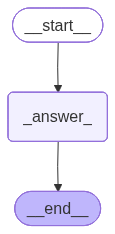

In [84]:
builder = StateGraph(ChatState)
builder.add_node('_answer_', answer_node)
builder.add_edge(START, '_answer_')
builder.add_edge('_answer_', END)

graph = builder.compile(checkpointer = checkpointer)
graph

### Testing Memory Chat

In [85]:
from pprint import pprint

cfg = {'configurable': {'thread_id': 'tread_test'}}
response = graph.invoke({'messages': [HumanMessage(content = 'Hello, my name is Nathan.')]}, config = cfg)
pprint(response)

{'messages': [HumanMessage(content='Hello, my name is Nathan.', additional_kwargs={}, response_metadata={}, id='c3435b37-783c-46d4-a0f2-65532907960c'),
              AIMessage(content='Hello, Nathan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 14, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Cfn94dZLN1yMaPdhmxn7pf57AMVRL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--55f3269c-d93c-4d41-a376-eb9f819ce47a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 11, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_de

In [86]:
response2 = graph.invoke({'messages': [HumanMessage(content = 'Do you remember what is my name?')]}, config = cfg)
pprint(response2)

{'messages': [HumanMessage(content='Hello, my name is Nathan.', additional_kwargs={}, response_metadata={}, id='c3435b37-783c-46d4-a0f2-65532907960c'),
              AIMessage(content='Hello, Nathan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 14, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Cfn94dZLN1yMaPdhmxn7pf57AMVRL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--55f3269c-d93c-4d41-a376-eb9f819ce47a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 11, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_de

In [98]:
for i in range(len(response2['messages'])):
  print(response2['messages'][i].content)

Hello, my name is Nathan.
Hello, Nathan! How can I assist you today?
Do you remember what is my name?
Yes, your name is Nathan. How can I help you today?
